In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *

In [2]:
#get raw lexicon list
ru_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_russian.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(ru_lex))

#debug raw lexicon
print(max(ru_lex,key=lambda item:item[1]))
ru_lex_dict = weightedlist2dict(ru_lex,lower=True) # no case-insensitive merge
print(len(ru_lex_dict))


99983
('не', 3164900)
91379


In [3]:
#get raw lexicon list
en_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_english.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(en_lex))

#debug raw lexicon
print(max(en_lex,key=lambda item:item[1]))
en_lex_dict = weightedlist2dict(en_lex,lower=True) # no case-insensitive merge
print(len(en_lex_dict))


97565
('the', 53097401)
97565


91379
98020


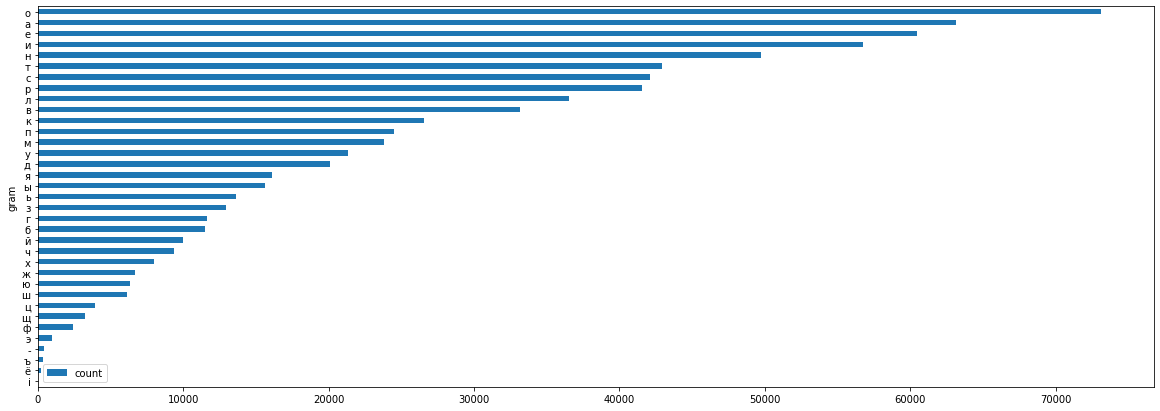

In [5]:
ru_lex_texts_no_count = list(ru_lex_dict)
print(len(ru_lex_texts_no_count))
lex_ru_base = FreedomTokenizer(max_n=3,mode='chars',debug=False)
lex_ru_base.train(ru_lex_texts_no_count)
print(lex_ru_base.count_params())
dic = dict([(key,lex_ru_base.model[0][key]) for key in lex_ru_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


97565
112334


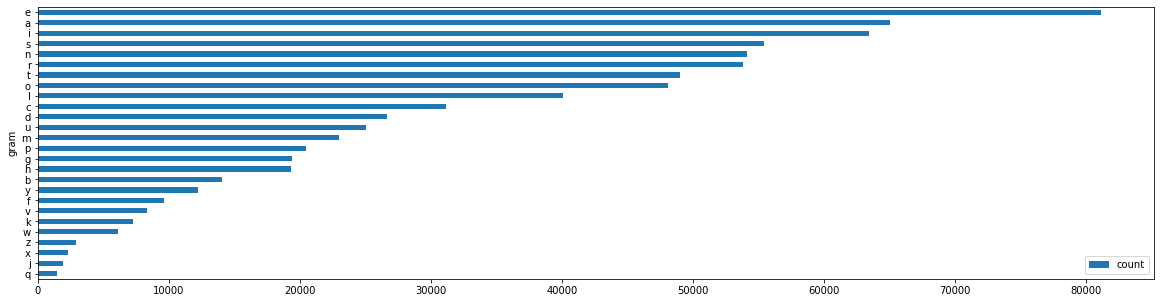

In [6]:
en_lex_texts_no_count = list(en_lex_dict)
print(len(en_lex_texts_no_count))
lex_en_base = FreedomTokenizer(max_n=3,mode='chars',debug=False)
lex_en_base.train(en_lex_texts_no_count)
print(lex_en_base.count_params())
dic = dict([(key,lex_en_base.model[0][key]) for key in lex_en_base.model[0] if len(key) == 1])
plot_dict(dic,'gram','count')


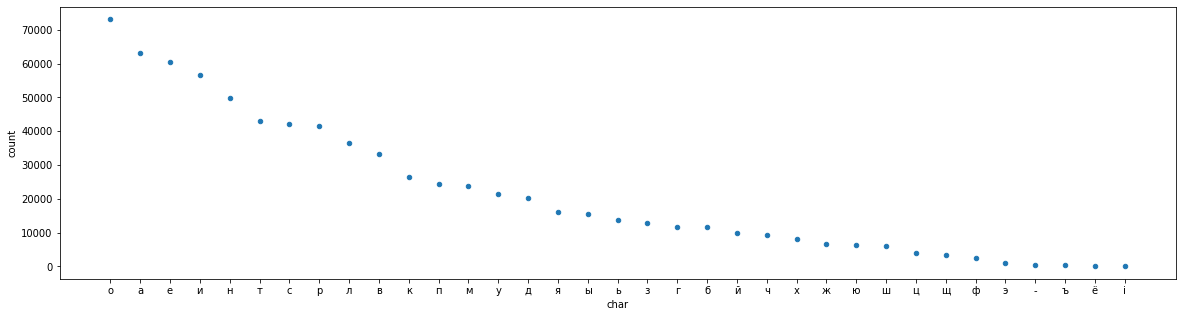

In [25]:
l = sorted([(key,lex_ru_base.model[0][key]) for key in lex_ru_base.model[0] if len(key) == 1],key=lambda x: x[1])
l.reverse()
df = pd.DataFrame(l,columns=['char','count'])
p = df.plot.scatter(x='char',y='count')


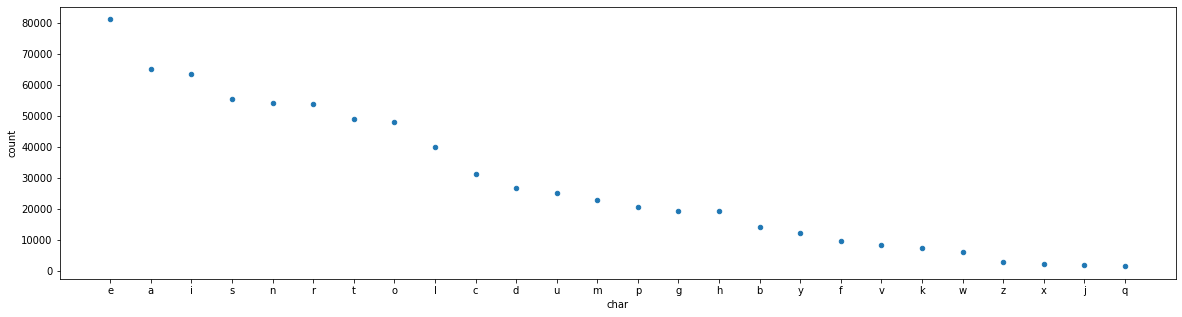

In [26]:
l = sorted([(key,lex_en_base.model[0][key]) for key in lex_en_base.model[0] if len(key) == 1],key=lambda x: x[1])
l.reverse()
df = pd.DataFrame(l,columns=['char','count'])
p = df.plot.scatter(x='char',y='count')


In [28]:
# https://www.thoughtco.com/common-prefixes-in-english-1692724
# https://www.learnenglish.de/grammar/prefixtext.html
# https://www.thoughtco.com/common-suffixes-in-english-1692725
# https://www.learnenglish.de/grammar/suffixtext.html
# https://englishstudyonline.org/suffix/
# https://www.learnthat.org/pages/view/suffix.html

#Suffix	Meaning	Example
en_suff = [
#Noun Suffixes:
'acy',#	state or quality	privacy, fallacy, delicacy
'al',#	act or process of	refusal, recital, rebuttal
'ance','ence',#	state or quality of	maintenance, eminence, assurance
'dom',#	place or state of being	freedom, kingdom, boredom
'er','or',#	one who	trainer, protector, narrator
'ism',#	doctrine, belief	communism, narcissism, skepticism
'ist',#	one who	chemist, narcissist, plagiarist
'ity','ty',#	quality of	inactivity, veracity, parity, serenity
'ment',#	condition of	argument, endorsement, punishment
'ness',#	state of being	heaviness, sadness, rudeness, testiness
'ship',#	position held	fellowship, ownership, kinship, internship
'sion','tion',#	state of being	concession, transition, abbreviation
#Verb Suffixes:
'ate',#	become	regulate, eradicate, enunciate, repudiate
'en',#	become	enlighten, awaken, strengthen
'ify','fy',#	make or become	terrify, satisfy, rectify, exemplify
'ize','ise',#*	become	civilize, humanize, socialize, valorize
#Adjective Suffixes:
'able','ible',#	capable of being	edible, presentable, abominable, credible
'al',#	pertaining to	regional, grammatical, emotional, coastal
'esque',#	reminiscent of	picturesque, statuesque, burlesque
'ful',#	notable for	fanciful, resentful, woeful, doubtful
'ic','ical',#	pertaining to	musical, mythic, domestic, chiastic
'ious','ous',#	characterized by	nutritious, portentous, studious
'ish',#	having the quality of	fiendish, childish, snobbish
'ive',#	having the nature of	creative, punitive, divisive, decisive
'less',#	without	endless, ageless, lawless, effortless
'y',#	characterized by	sleazy, hasty, greasy, nerdy, smelly
]

str(en_suff)


"['acy', 'al', 'ance', 'ence', 'dom', 'er', 'or', 'ism', 'ist', 'ity', 'ty', 'ment', 'ness', 'ship', 'sion', 'tion', 'ate', 'en', 'ify', 'fy', 'ize', 'ise', 'able', 'ible', 'al', 'esque', 'ful', 'ic', 'ical', 'ious', 'ous', 'ish', 'ive', 'less', 'y']"

In [ ]:
#TODO word disassembler based on suffixes and prefixes
#TODO experiment en ru



In [5]:
#https://github.com/ovalhub/pyicu/issues/81


In [6]:
from polyglot.text import Text, Word


ImportError: dlopen(/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/icu/_icu_.cpython-37m-darwin.so, 2): Symbol not found: __ZN6icu_7118AnnualTimeZoneRule8MAX_YEARE
  Referenced from: /Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/icu/_icu_.cpython-37m-darwin.so
  Expected in: flat namespace
 in /Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/icu/_icu_.cpython-37m-darwin.so